## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf

In [3]:
import tensorflow_datasets.public_api as tfds

In [4]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/lfw/0.1.0.incompleteHTE9X9/lfw-train.tfrecord*...:   0%|          | 0/13233 [0…

Dataset lfw downloaded and prepared to ~/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [5]:
train_ds2, test_ds2 = train_ds, test_ds

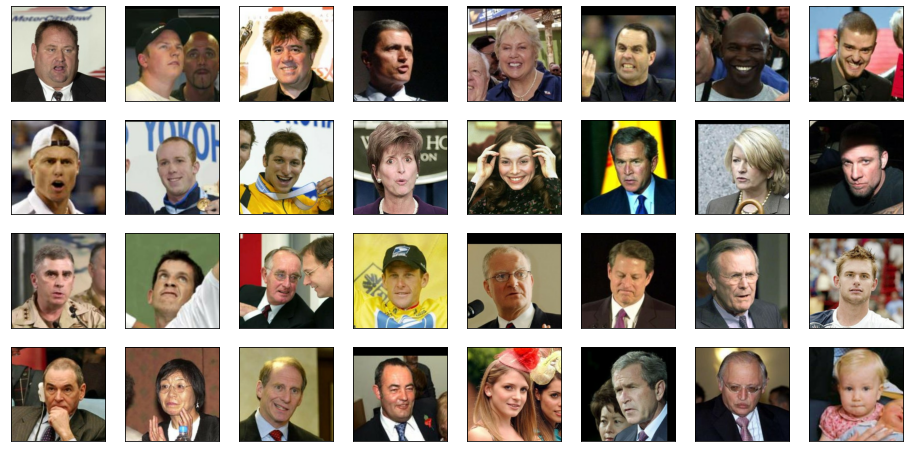

In [6]:
#visualization
some_samples = [x[1] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

In [7]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>

## Загрузка и подготовка датасета LFW

In [8]:
#dataset preparation, image resizing
INP_SIZE = 224
# NUM_EPOCHS = 10
BATCH_SIZE = 32

def prepare(label, img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128)

In [9]:
# test_ds = test_ds2.shuffle(buffer_size=1000)
# test_ds = test_ds.map(prepare)
# test_ds = test_ds.batch(32, drop_remainder=True)

## Создание модели CNN

In [10]:
EMB_SIZE = 32

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [11]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

# FRmodel = faceRecoModel(input_shape=(3, 250, 250))
def triplet_loss(y_true, y_pred, alpha = 0.3):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,
               positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, 
               negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
   
    return loss
# FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

## Подготовка пайплайна данных

In [12]:
# BATCH_SIZE = 32
# NUM_EPOCHS = 4

# train_ds = train_ds.shuffle(buffer_size=32)
# train_ds = train_ds.repeat(NUM_EPOCHS)
# train_ds = train_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [13]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [14]:
# model.compile(optimizer=optimizer,
#               loss=triplet_loss(),
#               metrics=['accuracy'])

## Обучение модели

In [15]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 93.21670532226562
[200] Loss: 3.540989398956299
CPU times: user 28.6 s, sys: 4.63 s, total: 33.2 s
Wall time: 1min 21s


## Получение эмбеддингов для тестовой выборки

In [16]:
test_ds_np = list(test_ds.as_numpy_iterator())

In [17]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [39]:
for element in test_ds:
  el1 = element
  break

In [56]:
import imageio
from skimage.transform import resize
img = imageio.imread('max1.jpg', pilmode="RGB")
img = img.astype(np.float32)/255
img = resize(img, (224, 224, 3), order=3, mode='reflect', anti_aliasing=True)
img = (1. - img).astype(np.float32)
img = np.mean(img, axis=2)

In [57]:
img.shape

(224, 224, 3)

In [58]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (224, 224, 3), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
    print(img.shape)
    img = np.reshape(img, (224, 224, 3))
    return img

img_a1 = load_and_prepare_image('max1.jpg')
img_a2 = load_and_prepare_image('max2.jpg')
img_b1 = load_and_prepare_image('andr.jpg')

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [50]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## Тестирование на новых данных

## Получение эмбеддингов для новых данных

In [59]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

## Вычисление расстояний между эмбеддингами

In [60]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  7.960252966383566
A2 <-> B1:  11.382941188359723
A1 <-> B1:  13.825217627800825
